# Approximating Fundemental Domain in Julia

## Fundemental domain using shortest cycle length

We will try to determine the size of the fundemental domain using cycle length. First, we will take snapshots of an image using only translational isometries. We will calculate the persistent homology, and reconstruct the 2 most persistent cycles. These should correspond to the shortest symmetric translations. If we take every integer translation of the lens (translate the lens only by 1 pixel each time), the length of these cycles will correspond to the number of pixels the lens corner had to move to reach an isomorphism. The Ripser package does not implement methods to reconstruct the cycles represented by persitence points, so we have to use Julia's Ripserer.

In [1]:
# Julia imports
using LinearAlgebra
using Plots
using Ripserer
using Images, FileIO
using OffsetArrays
using Distances

In [43]:
# Functions

function randSlice(img, lens_sz, trans, bound = 0)
    h::Int64, w::Int64= size(img)
    h2::Int64 = floor(h / 2)
    w2::Int64 = floor(w / 2)
    
    lx::Int64, ly::Int64 = lens_sz
    data = Array{Gray{N0f8}}(undef, ly, lx, trans)

    # if there isn't a boundary, take snapshots from the whole image.
    # Otherwise, stay inside the boundary.
    if bound == 0
        for k = 1:trans
            x = rand(1: w - lx - 1)
            y = rand(1: h - ly - 1)
            data[:,:,k] = @view img[y:y + ly - 1, x : x+ lx - 1]
        end
    else
        for k = 1:trans
            x = rand(w2 - bound : w2 + bound - lx - 1)
            y = rand(h2 - bound: h2 + bound - ly - 1)
            data[:,:,k] = @view img[y:y + ly - 1, x : x+ lx - 1]
        end
    end
    return data
end

function squareIso(img, lens_sz, square_bound)
    
    if square_bound > maximum(size(img)) / 2
        lens_range = minimum(size(img))
    else
        lens_range = square_bound
    end
    
    lx::Int64, ly::Int64 = lens_sz
    h, w = size(img)
    xst::Int64, xend::Int64 = floor(floor(w / 2) - lens_range), floor(floor(w / 2) + lens_range - lx)
    yst::Int64, yend::Int64 = floor(floor(h / 2) - lens_range), floor(floor(h / 2) + lens_range - ly)
    
    data = Array{Gray{N0f8}}(undef, ly, lx, (xend - xst + 1) * (yend - yst + 1))
    
    k::Int64 = 1
    for x::Int64 = xst : xend
        for y::Int64  in yst : yend
            data[:,:,k] = @view img[y:y + ly - 1, x : x+ lx - 1]
            k+=1
        end
    end
        
    return data
        
end

function arrayToPoints(img_list)
    y, x, z = size(img_list)
    point_list = Vector{Vector{Int64}}(undef, z)
    for k = 1:z
        point_list[k] = collect(Iterators.flatten(Int64.(rawview(channelview(img_list[:,:,k])))))

    end
    return point_list
end

function verticalSlice(img, lens_sz)
    h::Int64, w::Int64 = size(img)
    lx::Int64, ly::Int64 = lens_sz
    lens_corner_x::Int64= floor((w - lx) / 2)
    lens_corner_y::Int64= 1
    data = Array{Gray{N0f8}}(undef, ly, lx, h - ly + 1)
    
    while lens_corner_y <= h - ly + 1
        data[:,:,lens_corner_y] = @view img[lens_corner_y:lens_corner_y + ly - 1, lens_corner_x:lens_corner_x + lx - 1]
        lens_corner_y = lens_corner_y + 1
    end
    
    return data
end

function horizontalSlice(img, lens_sz)
    h::Int64, w::Int64 = size(img)
    lx::Int64, ly::Int64 = lens_sz
    lens_corner_y::Int64= floor((h - ly) / 2)
    lens_corner_x::Int64= 1
    data = Array{Gray{N0f8}}(undef, ly, lx, w - lx + 1)
    
    while lens_corner_x <= w - lx + 1
        data[:,:,lens_corner_x] = @view img[lens_corner_y:lens_corner_y + ly - 1, lens_corner_x:lens_corner_x + lx - 1]
        lens_corner_x = lens_corner_x + 1
    end
    
    return data
end

function imagesInCycle(reconstructed_at_birth, img_list)
    image_indexes = []
    # first we gather up the indices of the cycle
    for i in reconstructed_at_birth
        temp = vertices(i)
        push!(image_indexes, temp[1])
        push!(image_indexes, temp[2])
    end
    # next we sort them ascending, and remove duplicates
    sort!(image_indexes)
    image_indexes = unique(x->x, image_indexes)
    # now we use these indices to retrive the original images
    images = Array{Gray{N0f8}}(undef, 50, 50, size(image_indexes)[1])
    for (i,k) in zip(image_indexes,1:size(image_indexes)[1])
        images[:,:,k] = img_list[:,:,i]
    end
    # Here are the images displayed
    displ = mosaicview(images; fillvalue = .5, ncol = 5, npad = 2, rowmajor = true)
    percentage_scale = 4
    new_size = trunc.(Int, size(displ) .* percentage_scale)
    img_rescaled = imresize(displ, new_size)
end

imagesInCycle (generic function with 1 method)

We first experiment with a small C2 image.

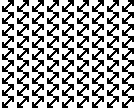

In [5]:
# first we load an image
img_path = "./images/testPersisC2.png"
img = Gray.(load(img_path))

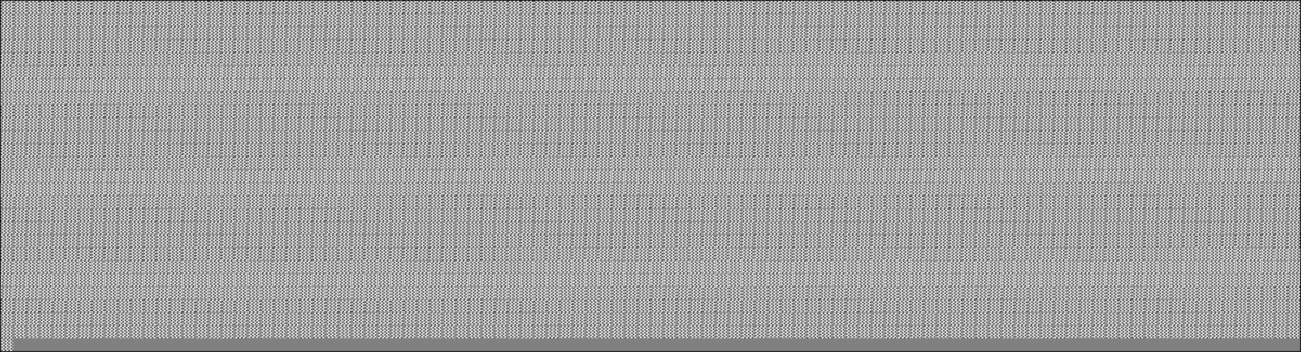

In [7]:
# here we take our snapshots; we have a lens size of 50 by 50
# and we take every crop possible from a 100 by 100 square
# centered around the middle of the image. This gives us 2601 cropped images.
img_list = squareIso(img, (50,50), 50)
mosaicview(img_list; fillvalue = .5, ncol = 100, npad = 2, rowmajor = true)

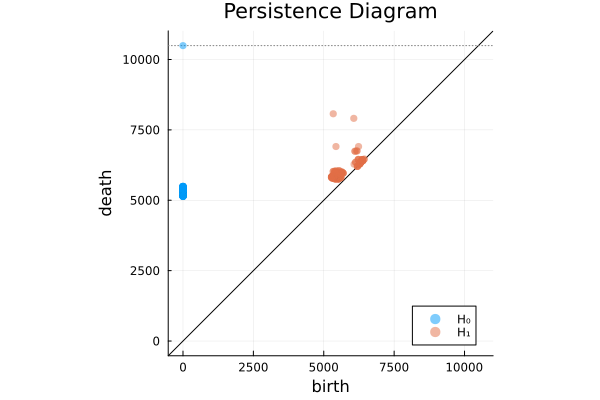

In [9]:
# we must turn our images into points
point_list_u = arrayToPoints(img_list)
# to improve calculation speed we only use the unique points
point_list_u = unique(x->x, point_list_u)
# note Ripserer uses Euclidean distance by default
diagram = ripserer(point_list_u; reps = true)
plot(diagram)

The diagram follows expectations; there are 2 outliers representing the 2 shortest independent translations that form translational symmetry.

In [20]:
most_persistent_co = diagram[2][end]
filtration = diagram[2].filtration

# points are ordered in increasing persistence, so this is the most persistent point
reconstructed_at_birth1 = reconstruct_cycle(filtration, diagram[2][end])

12-element Vector{Simplex{1, Float64, Int64}}:
 +Simplex{1}((153, 152), 5336.754631796369)
 +Simplex{1}((154, 153), 5336.754631796369)
 +Simplex{1}((155, 154), 5138.10762830052)
 +Simplex{1}((156, 155), 5157.055846119954)
 +Simplex{1}((156, 145), 5157.055846119954)
 +Simplex{1}((146, 145), 5175.934698197032)
 +Simplex{1}((147, 146), 5263.140697340325)
 +Simplex{1}((148, 147), 5263.140697340325)
 +Simplex{1}((149, 148), 5175.934698197032)
 +Simplex{1}((150, 149), 5157.055846119954)
 +Simplex{1}((151, 150), 5157.055846119954)
 +Simplex{1}((152, 151), 5138.10762830052)

In [21]:
reconstructed_at_birth2 = reconstruct_cycle(filtration, diagram[2][end - 1])

8-element Vector{Simplex{1, Float64, Int64}}:
 +Simplex{1}((90, 12), 6066.642399218863)
 +Simplex{1}((90, 78), 5250.77137190337)
 +Simplex{1}((78, 67), 5837.216802552394)
 +Simplex{1}((67, 56), 5820.483227361797)
 +Simplex{1}((56, 45), 5985.7142430958065)
 +Simplex{1}((45, 34), 5963.947937398515)
 +Simplex{1}((34, 23), 5859.453899468789)
 +Simplex{1}((23, 12), 5786.87091613421)

In [22]:
reconstructed_at_birth3 = reconstruct_cycle(filtration, diagram[2][end - 2])

15-element Vector{Simplex{1, Float64, Int64}}:
 +Simplex{1}((58, 46), 5433.355316928942)
 +Simplex{1}((70, 58), 5409.366876077089)
 +Simplex{1}((82, 70), 5409.366876077089)
 +Simplex{1}((94, 82), 5250.77137190337)
 +Simplex{1}((106, 94), 5361.067990615303)
 +Simplex{1}((118, 106), 5312.329997279913)
 +Simplex{1}((130, 118), 5287.792545098569)
 +Simplex{1}((142, 130), 5385.2715808954335)
 +Simplex{1}((154, 142), 5385.2715808954335)
 +Simplex{1}((166, 154), 5275.481020722186)
 +Simplex{1}((178, 166), 5300.075471160764)
 +Simplex{1}((178, 10), 5348.925125667773)
 +Simplex{1}((22, 10), 5250.77137190337)
 +Simplex{1}((34, 22), 5409.366876077089)
 +Simplex{1}((46, 34), 5409.366876077089)

By manually checking the image we confirm that the fundamental domain is 15 by 12 pixels. While the 2 correct cycles emerge with the correct length, the horizontal translation is less persistent than one of the noise cycles. We can use the indices from each cycle to observe the images that form each cycle:

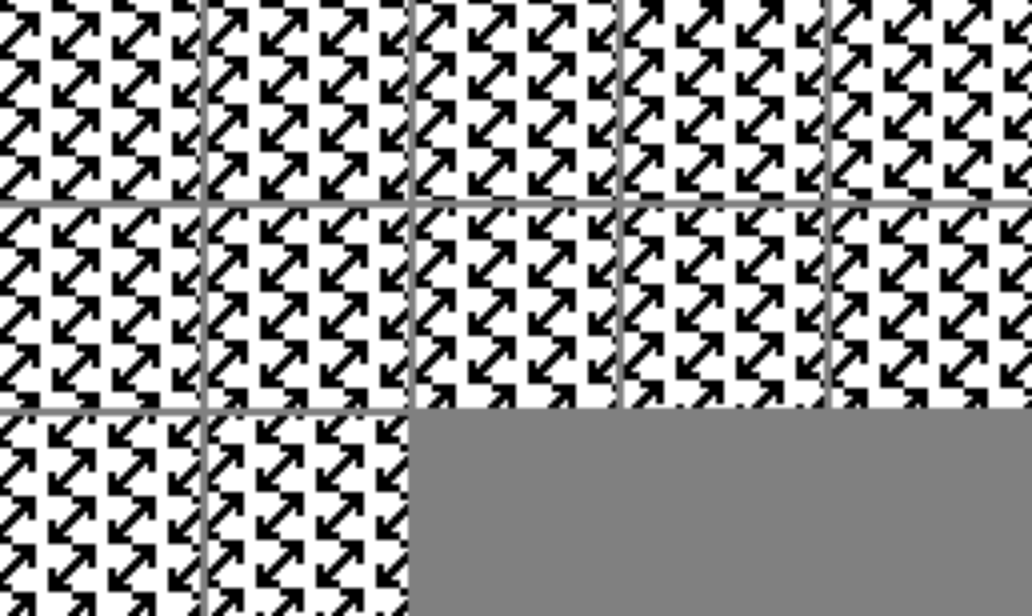

In [23]:
# cycle runs from left to right, row-wise
imagesInCycle(reconstructed_at_birth1, img_list)

This first cycle looks exactly how we would expect: it translates down by 1 pixel at each sucessive simplex, so this is the vertical cycle.

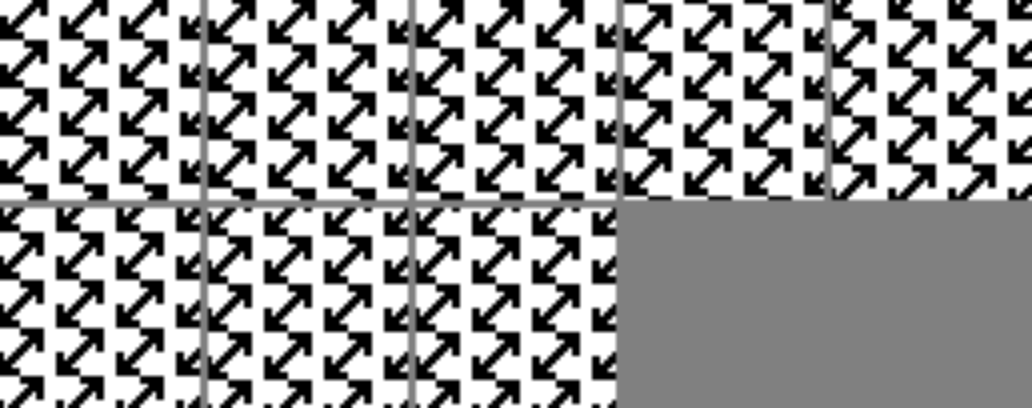

In [24]:
imagesInCycle(reconstructed_at_birth2, img_list)

Here is the noise cycle. Notice that it translates both vertically and a little horizontally.

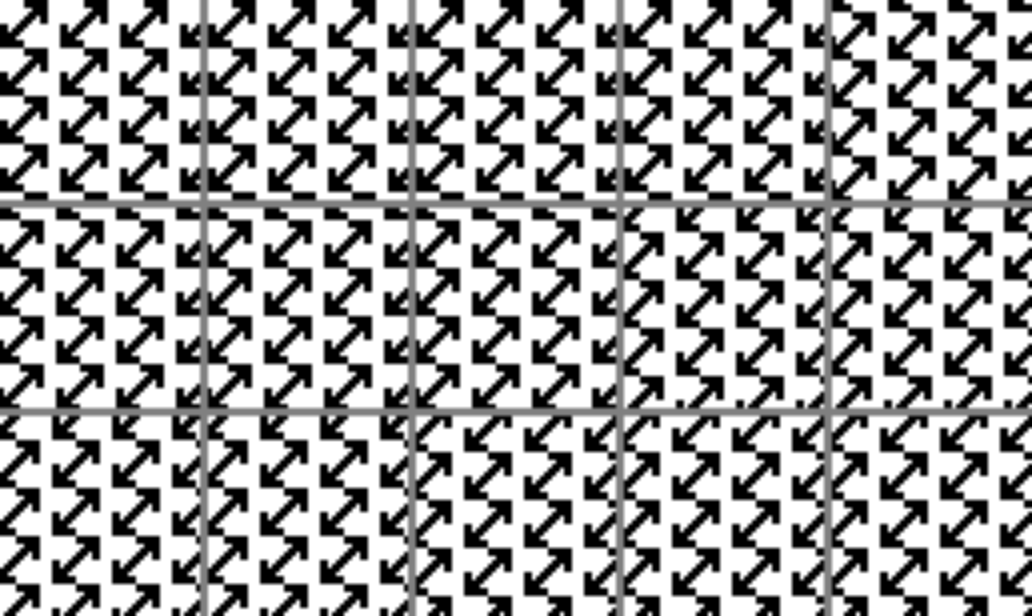

In [27]:
imagesInCycle(reconstructed_at_birth3, img_list)

This cycle is suprising. Instead of only travelling horizontally, it travels diagonally. These results show that this method can give decent estimations, but the cycles do not always form the way we might expect, and small images are vulnerable to noise. To improve speed, we will try a similar experiment using random translations within the image.

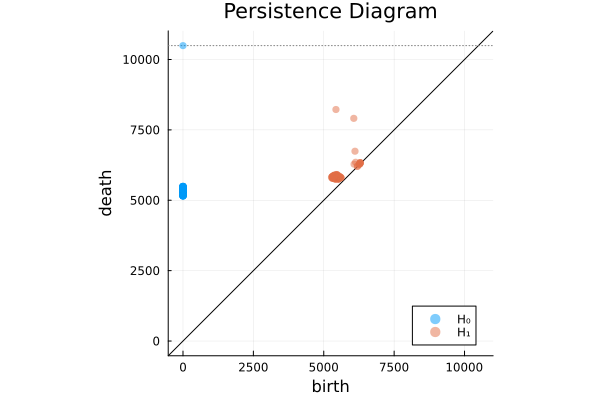

In [29]:
img_list = randSlice(img,(50,50),1000)
point_list = arrayToPoints(img_list)
point_list = unique(x->x, point_list)
diagram = ripserer(point_list; reps = true)
plot(diagram)

In [30]:
most_persistent_co = diagram[2][end]
filtration = diagram[2].filtration
reconstructed_at_birth1 = reconstruct_cycle(filtration, diagram[2][end])

15-element Vector{Simplex{1, Float64, Int64}}:
 +Simplex{1}((45, 24), 5433.355316928942)
 +Simplex{1}((94, 45), 5409.366876077089)
 +Simplex{1}((99, 94), 5409.366876077089)
 +Simplex{1}((99, 16), 5256.959672662517)
 +Simplex{1}((86, 16), 5367.129120861543)
 +Simplex{1}((86, 63), 5312.329997279913)
 +Simplex{1}((63, 59), 5287.792545098569)
 +Simplex{1}((59, 4), 5385.2715808954335)
 +Simplex{1}((5, 4), 5385.2715808954335)
 +Simplex{1}((108, 5), 5275.481020722186)
 +Simplex{1}((108, 96), 5300.075471160764)
 +Simplex{1}((96, 31), 5348.925125667773)
 +Simplex{1}((60, 31), 5250.77137190337)
 +Simplex{1}((67, 60), 5403.353125606358)
 +Simplex{1}((67, 24), 5403.353125606358)

In [31]:
reconstructed_at_birth2 = reconstruct_cycle(filtration, diagram[2][end - 1])

9-element Vector{Simplex{1, Float64, Int64}}:
 +Simplex{1}((90, 33), 6066.642399218863)
 +Simplex{1}((119, 90), 5348.925125667773)
 +Simplex{1}((119, 2), 5798.096670460057)
 +Simplex{1}((13, 2), 5792.486512716279)
 +Simplex{1}((74, 13), 5881.6069232821055)
 +Simplex{1}((106, 74), 5881.6069232821055)
 +Simplex{1}((106, 43), 5792.486512716279)
 +Simplex{1}((101, 43), 5798.096670460057)
 +Simplex{1}((101, 33), 5348.925125667773)

In [32]:
reconstructed_at_birth3 = reconstruct_cycle(filtration, diagram[2][end - 2])

4-element Vector{Simplex{1, Float64, Int64}}:
 +Simplex{1}((37, 16), 6109.365760862579)
 +Simplex{1}((110, 37), 5367.129120861543)
 +Simplex{1}((110, 55), 6077.351396784622)
 +Simplex{1}((55, 16), 5367.129120861543)

If we assume that the 2 most persistent points will always correspond to the 2 lengths of the fundamental domain, then this method outperforms the other in this case. 15 and 9 is a better approximation of 15 and 12 than 12 and 8. Note that this method cannot determine the direction of the basis vectors of the lattice, only their magnitude.
Next we try using this method with a larger image that has a parallelogram-shaped fundamental domain.

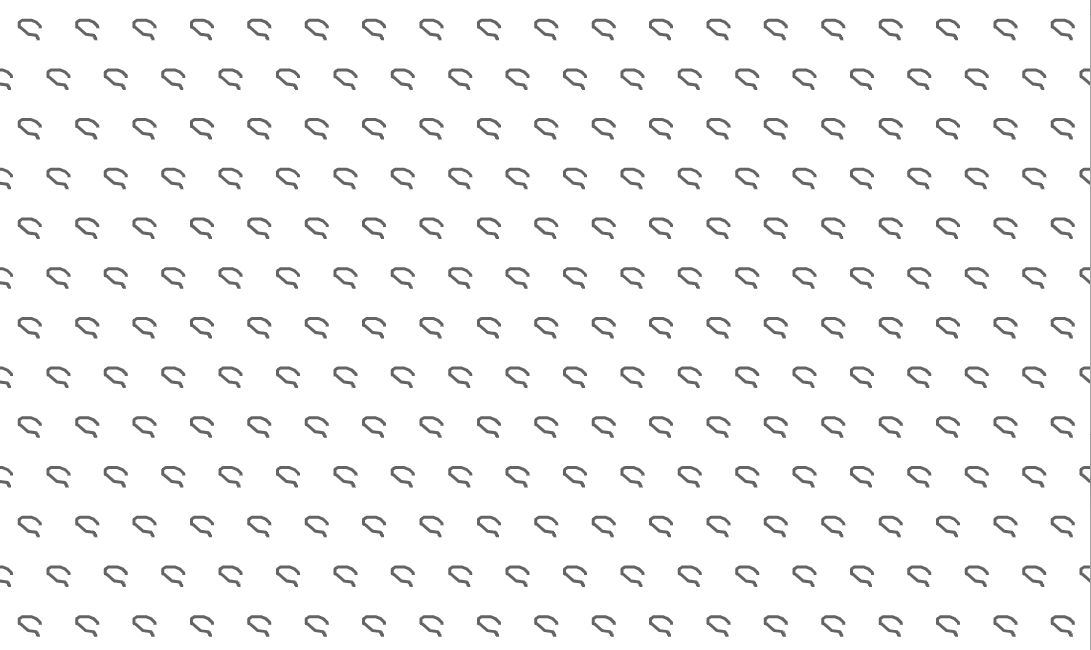

In [34]:
img_path = "./images/C1 horsehex.png"
img = Gray.(load(img_path))

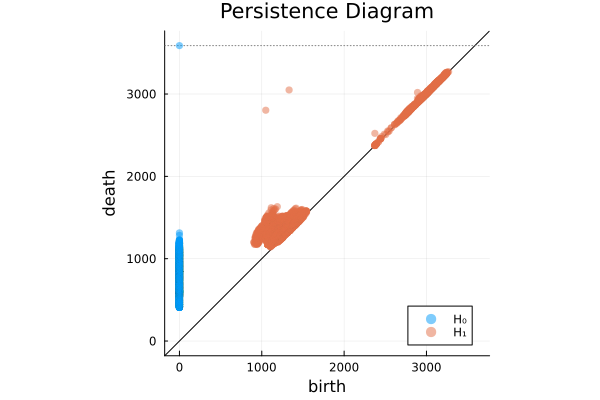

In [35]:
# because the fundemental domain is larger here, we must use
# a bigger lens and bounding square. We disscus this later.
# Note that this takes much longer to compute as a result.
img_list = squareIso(img, (70,70), 70)
point_list = arrayToPoints(img_list)
point_list = unique(x->x, point_list)
diagram = ripserer(point_list; reps = true)
plot(diagram)

In [36]:
most_persistent_co = diagram[2][end]
filtration = diagram[2].filtration
reconstructed_at_birth1 = reconstruct_cycle(filtration, diagram[2][end])

58-element Vector{Simplex{1, Float64, Int64}}:
 +Simplex{1}((1174, 1103), 1048.4059328332705)
 +Simplex{1}((1245, 1174), 1047.7852833476904)
 +Simplex{1}((1316, 1245), 1044.9186571212135)
 +Simplex{1}((1387, 1316), 1040.8477314189622)
 +Simplex{1}((1458, 1387), 1037.939304583847)
 +Simplex{1}((1529, 1458), 1028.9518939192444)
 +Simplex{1}((1600, 1529), 1002.5058603319983)
 +Simplex{1}((1671, 1600), 986.435502199713)
 +Simplex{1}((1742, 1671), 967.9855370820372)
 +Simplex{1}((1813, 1742), 924.3116357592822)
 +Simplex{1}((1884, 1813), 882.188188540291)
 +Simplex{1}((1955, 1884), 873.958236988473)
 +Simplex{1}((2026, 1955), 837.2693712300719)
 ⋮
 +Simplex{1}((4440, 4369), 975.8155563424883)
 +Simplex{1}((4511, 4440), 974.2843527430788)
 +Simplex{1}((4582, 4511), 946.8489847911334)
 +Simplex{1}((4653, 4582), 930.7185396240907)
 +Simplex{1}((4724, 4653), 930.2720032334629)
 +Simplex{1}((4795, 4724), 943.1935114280632)
 +Simplex{1}((4866, 4795), 951.8382215481788)
 +Simplex{1}((4937, 4866), 

In [38]:
reconstructed_at_birth1 = reconstruct_cycle(filtration, diagram[2][end - 1])

67-element Vector{Simplex{1, Float64, Int64}}:
 +Simplex{1}((3458, 3386), 1331.751102871704)
 +Simplex{1}((3458, 1350), 1223.9513879235565)
 +Simplex{1}((3459, 1350), 540.2804827124519)
 +Simplex{1}((3459, 1351), 1247.463025504163)
 +Simplex{1}((3460, 1351), 548.672944476033)
 +Simplex{1}((3460, 1352), 1262.6531590266584)
 +Simplex{1}((3461, 1352), 562.4482198389466)
 +Simplex{1}((3461, 1353), 1286.6483591098229)
 +Simplex{1}((3462, 1353), 598.3368616423361)
 +Simplex{1}((3462, 1354), 1300.7101906266437)
 +Simplex{1}((3463, 1354), 598.5123223459982)
 +Simplex{1}((3463, 1355), 1312.5623794700198)
 +Simplex{1}((3464, 1355), 598.6785447967883)
 ⋮
 +Simplex{1}((2949, 2877), 1077.6325904500104)
 +Simplex{1}((3021, 2949), 1077.6325904500104)
 +Simplex{1}((3093, 3021), 1077.6325904500104)
 +Simplex{1}((3165, 3093), 1077.6325904500104)
 +Simplex{1}((3166, 3165), 1171.4409929655014)
 +Simplex{1}((3167, 3166), 1171.4409929655014)
 +Simplex{1}((3168, 3167), 1201.3538196551422)
 +Simplex{1}((3169,

Manual measurements show that the fundamental domain two sides both with length 59. the cycle lengths approximate this pretty well, with lengths of 58 and 67. Next we try random translations.

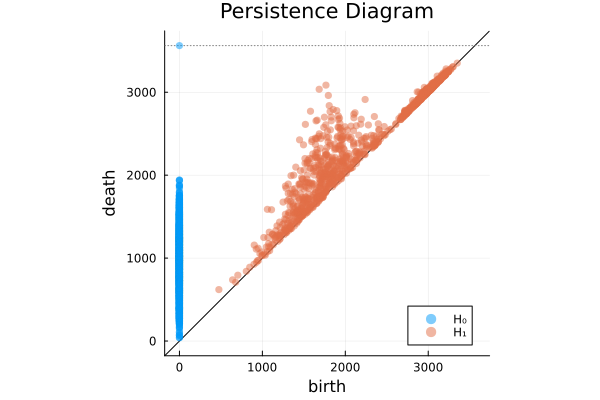

In [39]:
img_list = randSlice(img,(70,70),2000)
point_list = arrayToPoints(img_list)
point_list = unique(x->x, point_list)
diagram = ripserer(point_list; reps = true, modulus = 2)
plot(diagram)

In [40]:
most_persistent_co = diagram[2][end]
filtration = diagram[2].filtration
reconstructed_at_birth1 = size(reconstruct_cycle(filtration, diagram[2][end]))

(59,)

In [41]:
reconstructed_at_birth1 = size(reconstruct_cycle(filtration, diagram[2][end - 1]))

(70,)

The result is very similar and still close to ground truth, and also much faster. Next we try limiting the translations to a bounding square at centered at the center of the image.

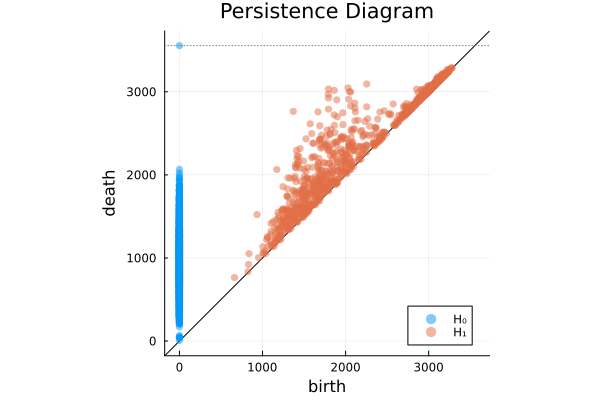

In [44]:
img_list = randSlice(img,(70,70),2000, 200)
point_list = arrayToPoints(img_list)
point_list = unique(x->x, point_list)
diagram = ripserer(point_list; reps = true, modulus = 2)
plot(diagram)

In [45]:
most_persistent_co = diagram[2][end]
filtration = diagram[2].filtration
reconstructed_at_birth1 = size(reconstruct_cycle(filtration, diagram[2][end]))

(60,)

In [46]:
reconstructed_at_birth1 = size(reconstruct_cycle(filtration, diagram[2][end - 1]))

(41,)

The results are worse than before. Note that the random selection of isometries is also responsible for results varying.

While these results are positive, we primarily want to know the size of the fundemental domain to speed up the computation of the point group in [appendix 2](./A2_determining_point_group.ipynb), and the long computation time makes this likely counterproductive. Additionally, we must set a boundary and lens size that will properly capture the fundamental domain. If the boundary is too small, then no cycle can be found at all. If the lens is too small, it might find isomorphisms smaller than the actual fundamental domain. Computation takes longer the more both parameters increase. If we naively set the lens size to one quarter of the image and the boundary to twice the lens, the result should be correct but the computation will take far too long. One idea to improve run time is to use a small lens that gets progressively larger until the result seems correct (how you would determine correctness is uncertain). Another concept is to take fixed translations at intervals bigger than 1 and then multiply the size of the persistent cycles by the interval. The idea is that the cycle should have $\dfrac{1}{\text{interval length}}$ as many simplices because the number of translations to reach an isomorphism needed would be divided by the same amount, along with the number of points that Ripserer would need to process. This would presumably increase speed at the cost of accuracy.